In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd

import warnings

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.dataretrival.data_retrival import get_goal_shots_by_season
    
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# import os
# os.chdir("/Users/raphaelbourque/Desktop/data_science_class/hockey-primer-1/")

In [4]:
# %run "/Users/raphaelbourque/Desktop/data_science_class/hockey-primer-1/modules/dataretrival/data_retrival.py"

In [5]:
class Directory:
    FIG_DIR = "../figures/" # Modify the path accordingly

In [6]:
# Format data frame with all years that we need
df = []
year = [2016, 2017, 2018, 2019, 2020]
for y in year:
    data = get_goal_shots_by_season(season_year=y)
    data['season'] = y
    df.append(data)
df = pd.concat(df)
print(df.shape)
df = df.dropna(axis=0, subset=['coordinates'])
print(df.shape)

(387829, 30)
(387812, 30)


In [7]:
# for i in df.columns:
#     print(i)

In [8]:
def plot_counts_by_shot_type_and_goal_proportion(df: pd.DataFrame, season: int) -> plt.figure:
    """
    This functions summarizes the data as a table of counts of events by type and secondary type, 
    and then produces a stacked barplot with annotations for percentage of goals over all shots for each shot type
    @param df: tidy data frame
    @return: seaborn figure
    """
    
    # Select the season
    df = df[df['season'] == season]
    
    # Produce a summary data frame 
    df.insert(0, 'count', 1)
    total_counts = df.groupby(['event_secondary_type','event']).count().reset_index()
    total_counts = total_counts.pivot(index='event_secondary_type', columns='event', values='count')
    total_counts['Goal'] = total_counts['Goal'].fillna(0)
    total_counts['Shot'] = total_counts['Shot'].fillna(0)
    
    # Plot  
    fig, ax = plt.subplots(figsize=(10, 8))
    # ax.set_yscale('log') # A log-scale makes the bars more visible but less intuitive
    total_counts.plot(kind='bar', stacked=True, color=['#a3acff', '#f9bc86'], ax=ax)
    ax.set(title='Goals and missed shots, by shot type, for season ' + str(season), xlabel='Shot type', ylabel='Count')
    
    # Add the percentages of goals over all shots as annotations in the plot
    total_counts['Proportion'] = (total_counts['Goal']/(total_counts['Shot'] + total_counts['Goal']))*100
    patches = ax.patches[:(len(ax.patches)//2)]
    for i, p in enumerate(patches): 
        h, w, x = p.get_height(), p.get_width(), p.get_x()
        xy = (x + w / 2., h + 600)
        text = total_counts['Proportion'][i]
        if np.isnan(text):
            text = 0
        text = f'{text:0.1f}%'
        ax.annotate(text=text, xy=xy, ha='center', va='center')
    plt.show()
    print(total_counts)
    
    # Save figure
    path = Directory.FIG_DIR + "figure_1_goals_by_shot_type_" + str(season) + ".png"
    fig.savefig(path)
    
    return plt.gcf()

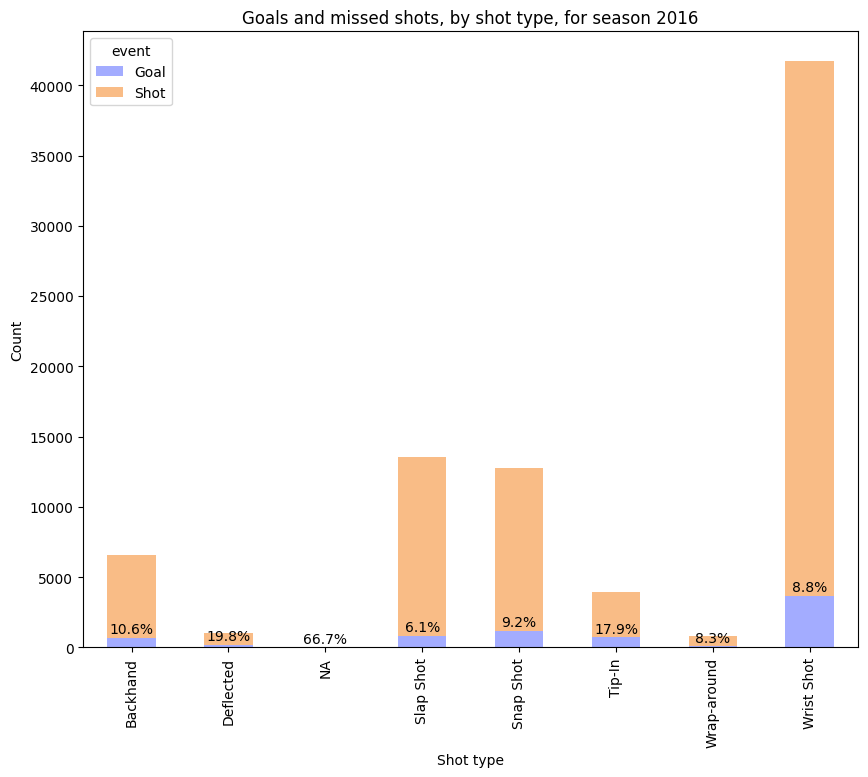

event                 Goal   Shot  Proportion
event_secondary_type                         
Backhand               698   5862   10.640244
Deflected              199    806   19.800995
NA                      12      6   66.666667
Slap Shot              829  12690    6.132110
Snap Shot             1172  11561    9.204429
Tip-In                 713   3267   17.914573
Wrap-around             70    773    8.303677
Wrist Shot            3681  38056    8.819513


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
plot_counts_by_shot_type_and_goal_proportion(df, 2016)

# Response to question 1:
The most dangerous types of shots for this 2016-2017 season are "deflected" (19.8% of success) followed by "tip-in" shots (17.9% of success). By "most dangerous", we mean that these shots are the ones that end up the most frequently by a successfull goal, as opposed to being missed. However, these are among the less frequent ones: there were only 806 "deflected" and 3,267 "tip-in" shots this season. On the contrary, the most common type of shots was by far the "wrist shot", with a total of 38,056 shots of that type for this season. 

We chose to illustrate this question with a barplot while overlaying the count of goals in blue overtop the total count of shots in orange (thus, toal of both goals and other, missed shots), by type of shot. Even though there is a large difference between the most common and less common types of shots, we chose to plot the absolute numbers and to keep the scale linear, because these are the most intuitive for the reader to understand the scale (the great number of goals involved in a same season) and not to be confuded with too many percentages on the same figure. We chose to add annotations on top of bars for the percentage of goals over all shots, because these proportion could not be visually abstracted simply from the figure, and this was an intuitive way to illustrate them.

In [10]:
# Add distinct columns for x and y coordinates
df['x_coordinate'] = df['coordinates'].apply(lambda x: x[0])
df['y_coordinate'] = df['coordinates'].apply(lambda x: x[1])

In [11]:
# Replace NAs by np.nan and type as float
df['x_coordinate'].replace({'NA': np.nan}, inplace = True)
df['x_coordinate'] = df['x_coordinate'].astype('float')
df['y_coordinate'].replace({'NA': np.nan}, inplace = True)
df['y_coordinate'] = df['y_coordinate'].astype('float')

In [12]:
def distance(x_coordinate: float, y_coordinate: float, shoot_side: str) -> float:
    """
    This functions computes the distance at which a shot was taken, i.e. the distance between the coordinates and the goal, 
    taking the goal side into account
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @param shoot_side: side of the goal at which the shot is aimed at
    @return: distance
    """
    x = np.nan
    y = np.nan
    if shoot_side == 'right':
        x = 89 - x_coordinate
        y = y_coordinate
    elif shoot_side == 'left':
        x = -89 - x_coordinate
        y = y_coordinate
    else: 
        pass
    distance = math.hypot(x,y)
    return distance

In [13]:
def distance_goal_relationship(df: pd.DataFrame) -> plt.figure:
    """
    This functions plots violin plots of distance as a function of goal or missed shot, 
    and then computes and plots a logistic regression between the distance a shot was taken and the outcome (goal)
    @param df: tidy data frame
    @return: plot
    """
    goal_percent_all_years = []
    for season in [2018, 2019, 2020]:
        
        # Select the season
        df1 = df.copy()
        df1 = df1[df1['season'] == season]

        # Add the side of the goal at which the shot is aimed - this is the opposite side of that of the team which is shooting
        df1.loc[(df1['action_team_name'] == df1['away_team']), 'shoot_side'] = df1.loc[(df1['action_team_name'] == df1['away_team']), 'home_team_side']
        df1.loc[(df1['action_team_name'] == df1['home_team']), 'shoot_side'] = df1.loc[(df1['action_team_name'] == df1['home_team']), 'away_team_side']

        # Compute the distance from the goal
        df1['distance'] = np.vectorize(distance)(df1['x_coordinate'], df1['y_coordinate'], df1['shoot_side'])

        # Categorize the distance
        b = [x for x in range(0,100,5)]
        lab = [str(x-2.5) for x in b]
        lab.pop(0)
        df1['distance_category'] = pd.cut(df1['distance'],bins=b,labels=lab)
        df1.insert(0, 'count', '1')
    
        # Format dataframe
        total_counts = df1.groupby(['distance_category']).count().reset_index()
        goal_counts = df1[df1.event == 'Goal']
        goal_counts = goal_counts.groupby(['distance_category']).count().reset_index()
        goal_percent = (goal_counts[['count']]/total_counts[['count']])*100
        goal_percent['distance_category'] = goal_counts['distance_category'].copy()
        # goal_percent[] = goal_percent.set_index(goal_counts['distance_category'])
        
        # Concatenate
        goal_percent.insert(0,'season',season)
        goal_percent_all_years.append(goal_percent)
        pass

    # Plot
    goal_percent_all_years = pd.concat(goal_percent_all_years)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(data=goal_percent_all_years, x='distance_category', y='count', hue='season')
    ax.set(title='Proportion of goals by distance', ylabel="Proportion of goals over all shots (%)", xlabel='distance category (ft)')
    plt.show()
    print(goal_percent_all_years)
    # Save figure
    path = Directory.FIG_DIR + "figure_2_goal_by_distance" + str(season) + ".png"
    fig.savefig(path)
    return plt.gcf()

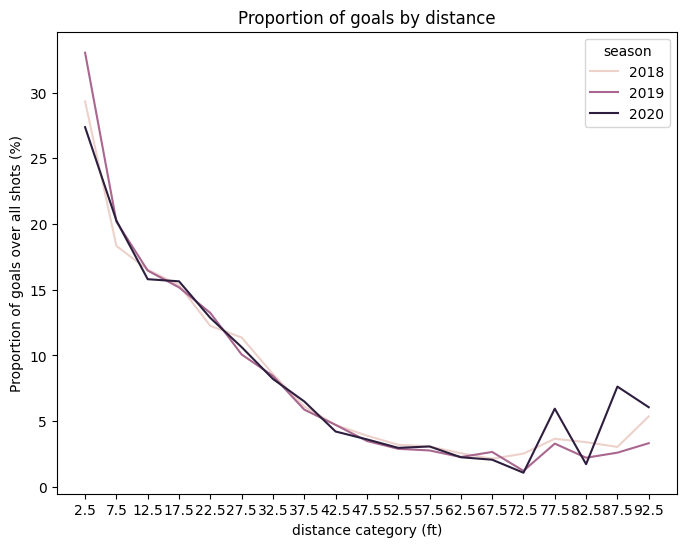

    season      count distance_category
0     2018  29.329609               2.5
1     2018  18.334657               7.5
2     2018  16.531804              12.5
3     2018  15.346171              17.5
4     2018  12.251495              22.5
5     2018  11.364688              27.5
6     2018   8.580106              32.5
7     2018   6.112760              37.5
8     2018   4.712126              42.5
9     2018   3.898917              47.5
10    2018   3.199576              52.5
11    2018   3.076923              57.5
12    2018   2.559119              62.5
13    2018   2.137133              67.5
14    2018   2.529183              72.5
15    2018   3.658537              77.5
16    2018   3.401361              82.5
17    2018   3.037975              87.5
18    2018   5.362776              92.5
0     2019  33.037694               2.5
1     2019  20.182371               7.5
2     2019  16.459087              12.5
3     2019  15.179689              17.5
4     2019  13.234722              22.5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
distance_goal_relationship(df)

# Response to question 2: 
The proportion of goals over all shots is increases overall exponentially as the distance diminishes, with a maximum proportion of goals >25% when goals are shot at less than 5 feet from the goal. We also note a small, local maximum at 75 to 80 feet. This distribution did not significantly for seasons 2018-19 to 2020-21. This local maximum could suggest that there is another variable (e.g. shot type or other) that could underly this distribution. 

We chose this figure after having considered and visualized different types of figures. First, we visualized violinplots of the distribution of goals and missed shots; however, these did not intuitively represent the chance (proportion) of goals over all shots per se, and the result was dependent on some assumption on the kernel size. We also experimented computing a logistic regression to predict goals from distance category, which worked fine. 

Finally, we chose to come back to the most simple and intuitive method, which is to bin the distance into categories, and plot the proportion of goals for each bin. We chose to divide the the distance into equal bins (as opposed to percentiles or other kind of distribution), in order to be able to  draw direct conclusion about the relationship of goals to the absolute value of distance by visualizing the figure. 

In [15]:
def distance_goal_relationship_by_type(df: pd.DataFrame, season: int) -> plt.figure:
    """
    This functions computes the percentage of goals over all shots, for each bin of distance and for each type of shot. 
    @param df: tidy data frame
    @return: distance
    """
    
    # Select the season
    df = df.loc[df['season'] == season]
    
    # Add the side of the goal at which the shot is aimed - this is the opposite side of that of the team which is shooting
    df.loc[(df['action_team_name'] == df['away_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['away_team']), 'home_team_side']
    df.loc[(df['action_team_name'] == df['home_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['home_team']), 'away_team_side']
    
    # Compute the distance from the goal
    df['distance'] = np.vectorize(distance)(df['x_coordinate'], df['y_coordinate'], df['shoot_side'])
    
    # Categorize the distance
    b = [x for x in range(0,100,5)]
    lab = [str(x-2.5) for x in b]
    lab.pop(0)
    df['distance_category'] = pd.cut(df['distance'],bins=b,labels=lab)
    df.insert(0, 'count', '1')
    
    # Format dataframe
    total_counts = df.groupby(['event_secondary_type','distance_category']).count().reset_index()
    total_counts = total_counts.pivot(index='distance_category', columns='event_secondary_type', values='count')
    goal_counts = df[df.event == 'Goal']
    goal_counts = goal_counts.groupby(['event_secondary_type','distance_category']).count().reset_index()
    goal_counts = goal_counts.pivot(index='distance_category', columns='event_secondary_type', values='count')
    goal_percent = (goal_counts/total_counts)*100
    goal_percent.drop('NA', inplace=True, axis=1)
    goal_percent[total_counts < 10] = np.nan # Remove values with less that 10 occurrences

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    goal_percent.plot(kind='line', stacked=False, ax=ax)
    ax.set(title='Proportion of goals by distance and shot type', ylabel="Proportion of goals over all shots (%)", xlabel='distance category (ft)')
    plt.show()
    print(goal_percent)
    
    # Save figure
    path = Directory.FIG_DIR + "figure_3_goals_by_distance_and_shot_type" + str(season) + ".png"
    fig.savefig(path)
    return plt.gcf()

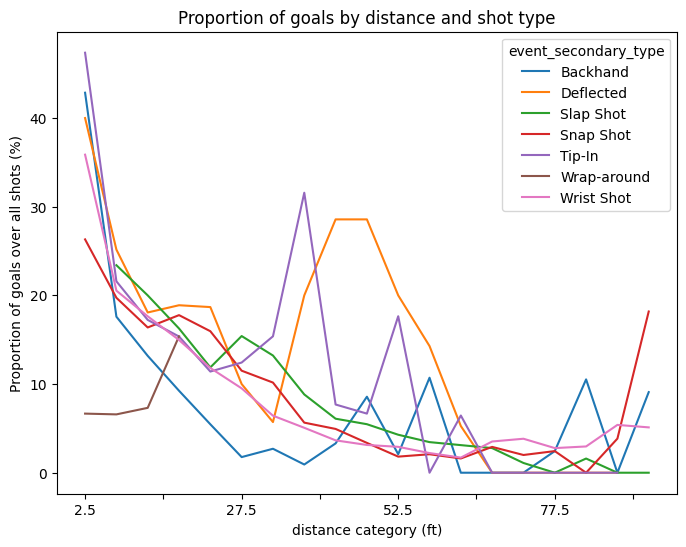

event_secondary_type   Backhand  Deflected  Slap Shot  Snap Shot     Tip-In  Wrap-around  Wrist Shot
distance_category                                                                                   
2.5                   42.857143  40.000000        NaN  26.315789  47.368421     6.666667   35.869565
7.5                   17.597403  25.165563  23.404255  19.729730  21.587031     6.578947   20.533752
12.5                  13.181818  18.072289  20.000000  16.381766  17.233010     7.317073   17.642105
17.5                   9.245283  18.888889  16.265060  17.773019  15.362731    15.384615   14.970222
22.5                   5.463576  18.681319  11.877395  15.958369  11.411411          NaN   11.813555
27.5                   1.763224  10.000000  15.413534  11.507402  12.426036          NaN    9.514371
32.5                   2.702703   5.714286  13.219094  10.167224  15.384615          NaN    6.431890
37.5                   0.925926  20.000000   8.828829   5.648958  31.578947          NaN   

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
distance_goal_relationship_by_type(df, 2017)

# Response to question 3: 

Overall, the most dangerous type of shot is the "tip-in" shot taken at a distance of less than 5 feet, followed closely by "back-hand" shots: more than 40% of these shots result in a goal. The relationship found in the previous questions, i.e. that the probability of a goal augments exponentially as the distance decreases, holds true overall for most types of shots. However, the "deflected" and "tip-in" shots have a second maximum between around 30 and 60 feet. 

Importantly, the "back-hand" shot has a second maximum at about 80 feet, and the slap-shot has a second maximum at more than 90 feet. This could explain the small local maximum at that distance that we observed in the global distribution of all shots at the previous figure. 

Finally, the curves are somewhat irregular, and adding more data (e.g. averaging through a few years) could add more smothness in the results. Note that to have more smoothed curves and remove outliers, we did not plot the points for which we had less than 10 total observations for that type of shot and at that distance in that season. 